# Our Ising 2D

We reproduce here the minimal freely available code for Ising simulation in Python provided Rajesh Singh,  Indian Institute of Technology (IIT) Madras. 

https://rajeshrinet.github.io/blog/2014/ising-model/


It is your starting point for a more complete and efficient implementation. 


In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from numba import njit

In [15]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------
def initialstate(N):   
    ''' generates a random spin configuration for initial condition'''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

@njit(fastmath = True)
def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config


@njit(fastmath = True)
def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

In [16]:
## change these parameters for a smaller (faster) simulation 
nt      = 200         #  number of temperature points
N       = 32         #  size of the lattice, N x N
eqSteps = 1024       #  number of MC sweeps for equilibration
mcSteps = 1024       #  number of MC sweeps for calculation

T       = np.linspace(1.53, 3.28, nt); 
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values

In [17]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    config = initialstate(N)
    iT=1.0/T[tt]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

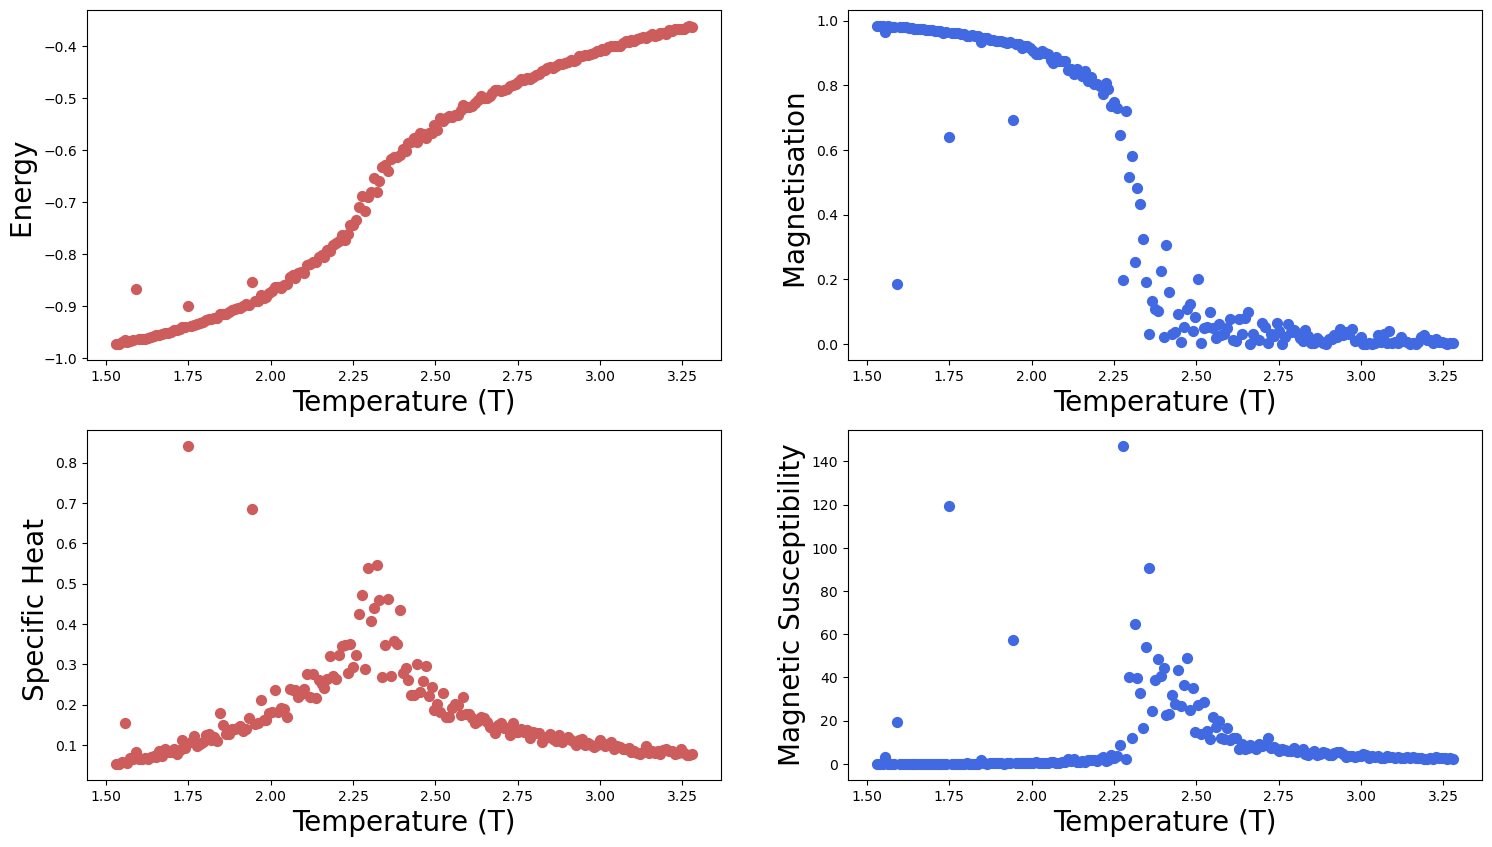

In [18]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetisation ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetic Susceptibility", fontsize=20);   plt.axis('tight');

# AdS / CFT correspondence section

### Define boundary operator:
Each bulk field $\phi(r, t, x)$ is dual to an operator $O(w, \bar{w})$ (written also as $O(w), \bar{O}(\bar{w})$)

where $w = \tau + i\phi$
and $\bar{w} = \tau - i\phi$
where $\tau \sim \tau + 2\pi$ is the thermal circle.
The thermal circle describes how $\tau$ runs along a circle of circumference of the inverse temperature $\beta$. We normally set this $\beta$ to $2\pi \implies T = \frac{1}{\beta} = \frac{1}{2\pi}$


In [ ]:
from scipy.optimize import curve_fit

def susc_model(T, A, Tc, gamma):
    return A * np.power(T-Tc, -gamma)

max_susc = np.argmax(X)
model_susc = X[max_susc+2:]
model_temp = T[max_susc+2:]
print(model_susc)
print(model_temp)

initial_guesses = [1.0,2.2,1.5]

params, covariance = curve_fit(susc_model, model_temp, model_susc, p0=initial_guesses)
A_fit, Tc_fit, gamma_fit = params

print(f"Extracted Tc: {Tc_fit:.4f}")
print(f"Extracted Gamma: {gamma_fit:.4f}")

# T_smooth = np.linspace(model_temp.min(), model_temp.max(), 500)
# chi_smooth = susc_model(T_smooth, A_fit, Tc_fit, gamma_fit)

# plt.scatter(model_temp, model_susc, color='red', label='Data Points', zorder=5)
# plt.plot(T_smooth, chi_smooth, color='blue', 
        #  label=f'Fit: $T_c={Tc_fit:.3f}$, $\gamma={gamma_fit:.3f}$')

# plt.xlabel('Temperature ($T$)')
# plt.ylabel('Susceptibility ($\chi$)')
# plt.title('Power-Law Fit for Ising Model Criticality')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.savefig('ising_fit_plot.png')
